In [1]:
# Create network with Keras
from keras.models import Sequential
from keras.layers import Dense
import keras
import numpy 
import numpy as np
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Using TensorFlow backend.


In [2]:
import pandas as pd
df1=pd.read_csv("MusicDelta_Rockabilly_MIX.wavfeatures.csv")
df2=pd.DataFrame.as_matrix(df1)
print (df2.shape)


df3=pd.read_csv("MusicDelta_Rockabilly_MELODY1.csvlabels.csv")
df4=pd.DataFrame.as_matrix(df3)
print (df4.shape)


(1620, 513)
(1620, 1)


In [3]:
# Mais amostras
df5 = np.zeros(shape=(df2.shape[0],1))
df5[:df4.shape[0],:] = df4

In [4]:
## create data
#X = np.random.random((360, 513))
# TEM QUE COLOCAR O VETOR DE LABELS AQUI!!!
#Y = keras.utils.to_categorical(np.random.normal(80, 20, size=(360, 1)), num_classes=180)
X = df2
Y = keras.utils.to_categorical(df5, num_classes=193)
x_test = np.random.random((100, 513))
y_test = keras.utils.to_categorical(np.random.normal(80, 20, size=(100, 1)), num_classes=193)

print (X.shape, Y.shape)

# create model
model = Sequential()
model.add(Dense(500, input_dim=513, activation='sigmoid'))
model.add(Dense(500, activation='sigmoid'))
model.add(Dense(193, activation='softmax'))

(1620, 513) (1620, 193)


In [5]:
print (X.shape, df2.shape)
print (Y.shape, df5.shape)

(1620, 513) (1620, 513)
(1620, 193) (1620, 1)


In [6]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Fit the model
model.fit(X, Y, epochs=2, batch_size=1)

Epoch 1/2
1620/1620 [==============================] - 15s - loss: 0.0218 - acc: 0.9948       

In [8]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1620/1620 [==============================] - 0s      224/1620 [===>..........................] - ETA: 0s

acc: 99.48%


In [9]:
# calculate predictions
predictions = model.predict(X)
# round predictions
#rounded = [round(x[0]) for x in predictions]
print(predictions)


[[  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 ..., 
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]]


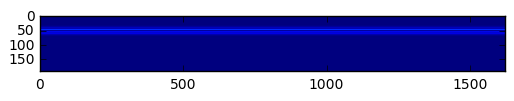

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the grid
plt.imshow(np.transpose(predictions))

plt.show()

In [11]:
print(predictions)

[[  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 ..., 
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]
 [  2.98837215e-01   3.22960568e-06   9.87843350e-07 ...,   1.48890570e-06
    1.05282913e-06   7.28955683e-07]]


In [ ]:
## Viterbi tracking

In [ ]:
class Trellis:
    trell = []
    def __init__(self, hmm, words):
        self.trell = []
        temp = {}
        for label in hmm.labels:
           temp[label] = [0,None]
        for word in words:
            self.trell.append([word,copy.deepcopy(temp)])
        self.fill_in(hmm)

    def fill_in(self,hmm):
        for i in range(len(self.trell)):
            for token in self.trell[i][1]:
                word = self.trell[i][0]
                if i == 0:
                    self.trell[i][1][token][0] = hmm.e(token,word)
                else:
                    max = None
                    guess = None
                    c = None
                    for k in self.trell[i-1][1]:
                        c = self.trell[i-1][1][k][0] + hmm.t(k,token)
                        if max == None or c > max:
                            max = c
                            guess = k
                    max += hmm.e(token,word)
                    self.trell[i][1][token][0] = max
                    self.trell[i][1][token][1] = guess

    def return_max(self):
        tokens = []
        token = None
        for i in range(len(self.trell)-1,-1,-1):
            if token == None:
                max = None
                guess = None
                for k in self.trell[i][1]:
                    if max == None or self.trell[i][1][k][0] > max:
                        max = self.trell[i][1][k][0]
                        token = self.trell[i][1][k][1]
                        guess = k
                tokens.append(guess)
            else:
                tokens.append(token)
                token = self.trell[i][1][token][1]
        tokens.reverse()
        return tokens